# Imports

In [94]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
import math
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Conv2D, MaxPool2D

In [95]:
from keras import backend as K
import tensorflow as tf
jobs = 11 # it means number of cores
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=jobs,
                         inter_op_parallelism_threads=jobs,
                         allow_soft_placement=True,
                         device_count={'CPU': jobs})
session = tf.compat.v1.Session(config=config)
K.set_session(session)

In [96]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

#df_train

In [97]:
df_train = pq.read_table('df_train.parquet')
df_train = df_train.to_pandas().drop_duplicates().dropna()
df_train

,st_code_snd,st_code_rsv,date_depart_year,date_depart_month,date_depart_week,date_depart_day,date_depart_hour,fr_id,route_type,is_load,...,common_ch,vidsobst,distance,snd_org_id,rsv_org_id,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id,y
0,wagonwagonwagontutu:)wagon,wagondigitalnewyearrailway:)happy,2021,11,45,12,14,3399.0,4.0,1,...,11.0,102.0,930.0,1098,5476,13,13,78,75,185.200000
1,railwaypgkhappyrailway:)railway,digitalhappynewyeardigital:)wagon,2021,4,15,17,16,2261.0,3.0,0,...,9.0,111.0,16.0,2974,6682,21,21,111,111,0.250000
2,railwaytutupgkpgk:)digital,pgkdigitalrailway:):)happy,2021,5,17,2,7,1089.0,3.0,1,...,9.0,111.0,879.0,2082,10729,9,9,67,23,109.133333
3,tuturailwaydigital2022:)digital,newyearnewyear20222022:)2022,2020,11,47,17,11,2261.0,4.0,0,...,975.0,103.0,8569.0,2974,10571,28,28,115,112,214.093056
4,railwaytutupgkpgk:)digital,pgkhappyrailwayhack:)railway,2020,12,52,25,5,1666.0,4.0,1,...,9.0,101.0,656.0,2082,9225,9,9,67,16,104.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4219365,tutunewyearwagonhack:)happy,newyearwagondigitaltutu:)pgk,2021,12,49,8,16,2261.0,4.0,0,...,19.0,102.0,1177.0,2974,1424,6,6,129,70,112.233333
4219366,happy:)pgkrailway:)2022,railwaypgkrailwaydigital:)2022,2022,1,1,5,0,1666.0,4.0,1,...,9.0,102.0,2078.0,1290,10282,32,32,29,59,115.816667
4219367,wagonwagon2022newyear:)railway,newyearwagondigital2022:)railway,2020,5,22,31,15,2261.0,3.0,0,...,9.0,101.0,5336.0,1098,2942,13,13,77,111,190.718889
4219368,newyearwagonhappytutu:)2022,newyearwagonpgkhack:)newyear,2021,3,12,24,20,2261.0,3.0,0,...,9.0,101.0,1886.0,2974,3107,32,32,29,31,49.583333


<AxesSubplot:>

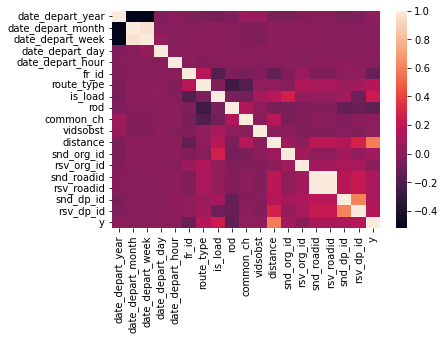

In [98]:
import seaborn as sns

sns.heatmap(df_train.corr())

In [99]:
# df_train = df_train.drop(columns=['rsv_dp_id', 'rod', 'common_ch', 'fr_id', 'rsv_org_id', 'vidsobst', 'snd_roadid', 'rsv_roadid', 'snd_dp_id'])

# Feature engineering

In [100]:
df_train

,st_code_snd,st_code_rsv,date_depart_year,date_depart_month,date_depart_week,date_depart_day,date_depart_hour,fr_id,route_type,is_load,...,common_ch,vidsobst,distance,snd_org_id,rsv_org_id,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id,y
0,wagonwagonwagontutu:)wagon,wagondigitalnewyearrailway:)happy,2021,11,45,12,14,3399.0,4.0,1,...,11.0,102.0,930.0,1098,5476,13,13,78,75,185.200000
1,railwaypgkhappyrailway:)railway,digitalhappynewyeardigital:)wagon,2021,4,15,17,16,2261.0,3.0,0,...,9.0,111.0,16.0,2974,6682,21,21,111,111,0.250000
2,railwaytutupgkpgk:)digital,pgkdigitalrailway:):)happy,2021,5,17,2,7,1089.0,3.0,1,...,9.0,111.0,879.0,2082,10729,9,9,67,23,109.133333
3,tuturailwaydigital2022:)digital,newyearnewyear20222022:)2022,2020,11,47,17,11,2261.0,4.0,0,...,975.0,103.0,8569.0,2974,10571,28,28,115,112,214.093056
4,railwaytutupgkpgk:)digital,pgkhappyrailwayhack:)railway,2020,12,52,25,5,1666.0,4.0,1,...,9.0,101.0,656.0,2082,9225,9,9,67,16,104.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4219365,tutunewyearwagonhack:)happy,newyearwagondigitaltutu:)pgk,2021,12,49,8,16,2261.0,4.0,0,...,19.0,102.0,1177.0,2974,1424,6,6,129,70,112.233333
4219366,happy:)pgkrailway:)2022,railwaypgkrailwaydigital:)2022,2022,1,1,5,0,1666.0,4.0,1,...,9.0,102.0,2078.0,1290,10282,32,32,29,59,115.816667
4219367,wagonwagon2022newyear:)railway,newyearwagondigital2022:)railway,2020,5,22,31,15,2261.0,3.0,0,...,9.0,101.0,5336.0,1098,2942,13,13,77,111,190.718889
4219368,newyearwagonhappytutu:)2022,newyearwagonpgkhack:)newyear,2021,3,12,24,20,2261.0,3.0,0,...,9.0,101.0,1886.0,2974,3107,32,32,29,31,49.583333


In [101]:
df_train['vidsobst_log'] = df_train['vidsobst'].apply(lambda x: math.log(x + 1))

In [102]:
df_train['y'] = df_train['y'].apply(lambda x: math.log(x + 1))

In [103]:
season_conv = {'winter': (1, 2, 12),
               'spring': (3, 4, 5),
               'summer': (6, 7, 8), 
               'autumn': (9, 10, 11)}

In [104]:
df_train['season'] = df_train['date_depart_month'].apply(lambda x: [k for k, v in season_conv.items() if x in season_conv[k]][0])

In [105]:
df_train['distance'] = df_train['distance'].apply(lambda x: math.log(x + 1))

In [106]:
df_train['distance^3'] = df_train['distance'].apply(lambda x: math.pow(x, 3))

In [107]:
df_train['distance^2'] = df_train['distance'].apply(lambda x: math.pow(x, 2))

In [108]:
# df_train['fr_id'] = df_train['fr_id'].apply(lambda x: math.log(x + 1))

# Dummies

In [109]:
df_train = pd.get_dummies(df_train, columns=['route_type', 'is_load', 
                                             'season', 
                                             'date_depart_month', 
                                             'date_depart_week',
                                             'date_depart_day'])

# Feature importance

In [110]:
# plt.figure(figsize=(16, 6))

# sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True).set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [111]:
X_train = df_train.loc[:, df_train.columns[2:]]
X_train = X_train.loc[:, X_train.columns != 'y']
y_train = df_train['y']

In [112]:
bestfeatures = SelectKBest(score_func = f_regression, k = 'all')
fit = bestfeatures.fit(X_train, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']  
print(featureScores.nlargest(15, 'Score')) 

          Features         Score
6         distance  8.755009e+06
15      distance^2  7.526744e+06
14      distance^3  5.799130e+06
20       is_load_1  3.993559e+05
19       is_load_0  3.993559e+05
2            fr_id  2.081755e+05
18  route_type_4.0  1.446094e+05
9       snd_roadid  1.006614e+05
10      rsv_roadid  1.006614e+05
17  route_type_3.0  6.371839e+04
3              rod  5.898547e+04
16  route_type_1.0  4.058513e+04
12       rsv_dp_id  3.818322e+04
7       snd_org_id  2.461652e+04
5         vidsobst  4.871498e+03


In [113]:
X_train = X_train[featureScores.nlargest(15, 'Score')['Features']]

# Preprocessing

In [114]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

# Model creation

In [115]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  
  return model

In [116]:
dnn_model = build_and_compile_model(normalizer)

In [117]:
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 15)               31        
 ion)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                1024      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,440
Trainable params: 9,409
Non-trainable params: 31
___________________________________________________

In [118]:
%%time
history = dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=1, epochs=10)

Epoch 1/10
99990/99990 [==============================] - 98s 973us/step - loss: 0.3965 - val_loss: 0.3666
Epoch 2/10
99990/99990 [==============================] - 99s 995us/step - loss: 0.3609 - val_loss: 0.3561
Epoch 3/10
99990/99990 [==============================] - 101s 1ms/step - loss: 0.3504 - val_loss: 0.3568
Epoch 4/10
99990/99990 [==============================] - 97s 969us/step - loss: 0.3449 - val_loss: 0.3442
Epoch 5/10
99990/99990 [==============================] - 97s 971us/step - loss: 0.3408 - val_loss: 0.3400
Epoch 6/10
99990/99990 [==============================] - 98s 981us/step - loss: 0.3377 - val_loss: 0.3363
Epoch 7/10
99990/99990 [==============================] - 97s 975us/step - loss: 0.3355 - val_loss: 0.3339
Epoch 8/10
99990/99990 [==============================] - 97s 974us/step - loss: 0.3335 - val_loss: 0.3467
Epoch 9/10
99990/99990 [==============================] - 98s 980us/step - loss: 0.3323 - val_loss: 0.3368
Epoch 10/10
99990/99990 [=============

In [119]:
test_predictions = dnn_model.predict(X_train).flatten()

mean_squared_error(test_predictions, y_train, squared=False)

124987/124987 [==============================] - 77s 614us/step


0.5724836216886778

In [120]:
mean_squared_error(pd.Series(test_predictions).apply(lambda x: math.exp(x) - 1), y_train.apply(lambda x: math.exp(x) - 1), squared=False)

89.41944756118066

In [121]:
r2_score(test_predictions, y_train)

0.8314399948707354

#df_test

In [122]:
df_test = pq.read_table('df_test.parquet')
df_test = df_test.to_pandas()
df_test

,st_code_snd,st_code_rsv,date_depart_year,date_depart_month,date_depart_week,date_depart_day,date_depart_hour,fr_id,route_type,is_load,rod,common_ch,vidsobst,distance,snd_org_id,rsv_org_id,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id
0,happy:)pgkwagon:):),pgk2022newyear:)pgk,2022,9,35,1,9,2261.0,3.0,0,2,10.0,102.0,2930.0,2974,2847,28,28,134,125
1,2022newyear:)newyear:):),hacktutu:)newyear:)2022,2022,8,34,22,14,1653.0,4.0,1,8,9.0,102.0,1728.0,2957,6340,18,18,102,16
2,happyrailwaytutu:)pgk,newyeartutu:)hack:)newyear,2022,5,21,26,16,643.0,3.0,1,8,9.0,102.0,4393.0,1664,2128,0,0,1,124
3,2022tuturailwayhack:):),2022newyear:)happy:)pgk,2022,11,44,4,4,2261.0,4.0,0,8,975.0,111.0,1111.0,2974,2468,32,32,29,31
4,happyrailwaytutu:)pgk,pgk2022newyear:)pgk,2022,5,20,17,6,2261.0,3.0,0,15,40.0,111.0,19.0,2974,1098,29,29,117,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182898,pgknewyeardigitalhack:)hack,hack:)tutu:)railway,2022,6,26,27,19,539.0,4.0,1,2,10.0,102.0,1627.0,1416,14179,32,32,123,3
1182899,tutupgkdigitalrailway:)hack,happyrailwaytutu:)pgk,2022,9,39,27,16,1677.0,3.0,1,8,975.0,102.0,5096.0,2129,1664,27,27,125,1
1182900,digitalhappynewyeardigital:)wagon,railwaytutupgkhappy:)newyear,2022,7,30,27,23,618.0,1.0,1,8,975.0,102.0,276.0,1316,2082,9,9,67,67
1182901,hacknewyear:)pgk:)happy,hacktutupgkwagon:)railway,2022,7,30,26,14,100056.0,4.0,0,2,10.0,102.0,408.0,2974,3392,0,0,1,0


In [123]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")

df_test.loc[:, df_test.columns[2:]] = imputer.fit_transform(df_test.loc[:, df_test.columns[2:]])

In [124]:
df_test

,st_code_snd,st_code_rsv,date_depart_year,date_depart_month,date_depart_week,date_depart_day,date_depart_hour,fr_id,route_type,is_load,rod,common_ch,vidsobst,distance,snd_org_id,rsv_org_id,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id
0,happy:)pgkwagon:):),pgk2022newyear:)pgk,2022.0,9.0,35.0,1.0,9.0,2261.0,3.0,0.0,2.0,10.0,102.0,2930.0,2974.0,2847.0,28.0,28.0,134.0,125.0
1,2022newyear:)newyear:):),hacktutu:)newyear:)2022,2022.0,8.0,34.0,22.0,14.0,1653.0,4.0,1.0,8.0,9.0,102.0,1728.0,2957.0,6340.0,18.0,18.0,102.0,16.0
2,happyrailwaytutu:)pgk,newyeartutu:)hack:)newyear,2022.0,5.0,21.0,26.0,16.0,643.0,3.0,1.0,8.0,9.0,102.0,4393.0,1664.0,2128.0,0.0,0.0,1.0,124.0
3,2022tuturailwayhack:):),2022newyear:)happy:)pgk,2022.0,11.0,44.0,4.0,4.0,2261.0,4.0,0.0,8.0,975.0,111.0,1111.0,2974.0,2468.0,32.0,32.0,29.0,31.0
4,happyrailwaytutu:)pgk,pgk2022newyear:)pgk,2022.0,5.0,20.0,17.0,6.0,2261.0,3.0,0.0,15.0,40.0,111.0,19.0,2974.0,1098.0,29.0,29.0,117.0,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182898,pgknewyeardigitalhack:)hack,hack:)tutu:)railway,2022.0,6.0,26.0,27.0,19.0,539.0,4.0,1.0,2.0,10.0,102.0,1627.0,1416.0,14179.0,32.0,32.0,123.0,3.0
1182899,tutupgkdigitalrailway:)hack,happyrailwaytutu:)pgk,2022.0,9.0,39.0,27.0,16.0,1677.0,3.0,1.0,8.0,975.0,102.0,5096.0,2129.0,1664.0,27.0,27.0,125.0,1.0
1182900,digitalhappynewyeardigital:)wagon,railwaytutupgkhappy:)newyear,2022.0,7.0,30.0,27.0,23.0,618.0,1.0,1.0,8.0,975.0,102.0,276.0,1316.0,2082.0,9.0,9.0,67.0,67.0
1182901,hacknewyear:)pgk:)happy,hacktutupgkwagon:)railway,2022.0,7.0,30.0,26.0,14.0,100056.0,4.0,0.0,2.0,10.0,102.0,408.0,2974.0,3392.0,0.0,0.0,1.0,0.0


In [125]:
df_test['vidsobst_log'] = df_test['vidsobst'].apply(lambda x: math.log(x + 1))

In [126]:
season_conv = {'winter': (1, 2, 12),
               'spring': (3, 4, 5),
               'summer': (6, 7, 8), 
               'autumn': (9, 10, 11)}

In [127]:
df_test['season'] = df_test['date_depart_month'].apply(lambda x: [k for k, v in season_conv.items() if x in season_conv[k]][0])

In [128]:
df_test['distance'] = df_test['distance'].apply(lambda x: math.log(x + 1))

In [129]:
df_test['distance^3'] = df_test['distance'].apply(lambda x: math.pow(x, 3))

In [130]:
df_test['distance^2'] = df_test['distance'].apply(lambda x: math.pow(x, 2))

In [131]:
df_test = pd.get_dummies(df_test, columns=['route_type', 'is_load', 
                                             'season', 
                                             'date_depart_month', 
                                             'date_depart_week',
                                             'date_depart_day'])

In [132]:
df_test.rename(columns={'is_load_0.0': 'is_load_0', 'is_load_1.0': 'is_load_1'}, inplace=True)

In [133]:
df_test = df_test[featureScores.nlargest(15, 'Score')['Features']]

In [134]:
df_test

,distance,distance^2,distance^3,is_load_1,is_load_0,fr_id,route_type_4.0,snd_roadid,rsv_roadid,route_type_3.0,rod,route_type_1.0,rsv_dp_id,snd_org_id,vidsobst
0,7.983099,63.729869,508.761847,0,1,2261.0,0,28.0,28.0,1,2.0,0,125.0,2974.0,102.0
1,7.455298,55.581476,414.376490,1,0,1653.0,1,18.0,18.0,0,8.0,0,16.0,2957.0,102.0
2,8.387995,70.358464,590.166465,1,0,643.0,0,0.0,0.0,1,8.0,0,124.0,1664.0,102.0
3,7.013915,49.195010,345.049644,0,1,2261.0,1,32.0,32.0,0,8.0,0,31.0,2974.0,111.0
4,2.995732,8.974412,26.884935,0,1,2261.0,0,29.0,29.0,1,15.0,0,117.0,2974.0,111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182898,7.395108,54.687616,404.420799,1,0,539.0,1,32.0,32.0,0,2.0,0,3.0,1416.0,102.0
1182899,8.536407,72.870251,622.050155,1,0,1677.0,0,27.0,27.0,1,8.0,0,1.0,2129.0,102.0
1182900,5.624018,31.629573,177.885272,1,0,618.0,0,9.0,9.0,0,8.0,1,67.0,1316.0,102.0
1182901,6.013715,36.164770,217.484625,0,1,100056.0,1,0.0,0.0,0,2.0,0,0.0,2974.0,102.0


In [135]:
test_predictions = dnn_model.predict(df_test).flatten()

36966/36966 [==============================] - 21s 567us/step


In [136]:
df_out = pd.DataFrame(test_predictions)

In [137]:
df_out.columns = ['time']
df_out

,time
0,5.405885
1,5.071385
2,5.306222
3,4.587904
4,2.329891
...,...
1182898,5.247160
1182899,5.620998
1182900,1.974872
1182901,4.388227


In [138]:
df_out.time = df_out.time.astype('float64').apply(lambda x: math.exp(x) - 1)

In [139]:
df_out

,time
0,221.713177
1,158.394998
2,200.587184
3,97.288200
4,9.276819
...,...
1182898,189.025911
1182899,275.164964
1182900,6.205697
1182901,79.497607


In [140]:
df_out.isna().sum()

time    0
dtype: int64

In [141]:
df_out.to_csv('sub_example.csv', index=False)